<a href="https://colab.research.google.com/github/AlexanderAlmeida/pos_graduacao/blob/master/MVP_Consignado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Crédito Consignado

- O objetivo principal é criar uma predição para poder conceder crédito consignado as pessoas com matrícula federal. A regrá principal consiste em ser menor que 85 anos de idade, com margem de saldo superior à 35% dos parcelamentos vigentes. Treinaremos modelos de machine learning para o problema de classificação.

**Dataset**

 O dataset possui 5000 instâncias e 8 atributos, com um mix de tipos de dados categóricos e numéricos. Abaixo a descrição das colunas:

Colunas:
- Sexo: sexo do cidadão
- Idade: idade do cidadão
- UF: unidade federativa
- Situação Funcional: Aposentado / Ativo e etc...
- Tipo Contrato: Estável (Aposentadoria estávle) / Não Estável (Cidadão pode perder a aposentadoria ou pensão
- Pmt_Valor: Valor total dos parcelamentos vigentes
- Margem_Saldo: Valor total disponível para cessão de crédito
- Conceder: Classe de saída: 0 - CONCEDER e 1 - NÃO CONCEDER










**Realizar as importações necessárias para o projeto**

In [19]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd # para importação do dataset
import numpy as np #
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from imblearn.over_sampling import SMOTE # tratamento do balanceamento por Oversampling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler # realiza o ajuste de escalonamento
from sklearn.preprocessing import LabelEncoder # para converter variáveis categóticas
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import StratifiedKFold # estratificação dos Kfolds
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # para matriz de confusão
from sklearn.pipeline import Pipeline # para criação dos pipelines
from sklearn.linear_model import LogisticRegression # algorítmo de regressão logistica
from sklearn.tree import DecisionTreeClassifier # algorítmos arvore de classificação
from sklearn.neighbors import KNeighborsClassifier # algorítmos KNN
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVC
from sklearn.ensemble import BaggingClassifier # ensemble Bagging
from sklearn.ensemble import RandomForestClassifier # ensemble RF
from sklearn.ensemble import ExtraTreesClassifier # ensemble ExtraTree
from sklearn.ensemble import VotingClassifier # ensemblre Voting
from sklearn.ensemble import AdaBoostClassifier # ensembel ADA Boost
from sklearn.ensemble import GradientBoostingClassifier # ensemble GradientBoost
from sklearn.ensemble import HistGradientBoostingClassifier # ensemble GradientBoost
from statistics import mean

**Carregando os dados históricos da base de consignado**

In [20]:
# Carregar os dados

url = "https://raw.githubusercontent.com/AlexanderAlmeida/pos_graduacao/master/consignado_final.csv"
data_consig = pd.read_csv(url, delimiter=',') # leitura do dataset consignado
data_consig.head() # exibição das 5 primeiras linhas do dataset

,sexo,idade,uf,situacao_funcional,tipo_contrato,pmt_valor,margem_saldo,conceder
0,MASCULINO,40,BA,ATIVO PERMANENTE,ESTAVEL,2011.71,-1309.80,1
1,MASCULINO,40,BA,ATIVO PERMANENTE,ESTAVEL,3129.31,1104.00,1
2,MASCULINO,38,MS,ATIVO PERMANENTE,ESTAVEL,976.12,235.91,1
3,MASCULINO,38,MS,ATIVO PERMANENTE,ESTAVEL,2960.64,3684.51,1
4,FEMININO,89,PR,APOSENTADO,ESTAVEL,422.80,12923.68,1


**Analisando o dataset em busca de discrepâncias e desbalanceamentos**

In [21]:
# Observando as discrepâncias
data_consig.describe()

,idade,pmt_valor,margem_saldo,conceder
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,60.872800,2254.081078,4016.961542,0.620000
std,21.362956,2783.735305,7537.710985,0.485435
min,16.000000,6.550000,-45820.720000,0.000000
25%,39.000000,393.732500,170.040000,0.000000
50%,54.000000,1438.020000,2219.540000,1.000000
75%,83.000000,2990.740000,5872.812500,1.000000
max,122.000000,27418.010000,93084.390000,1.000000


*** Podemos verificar um pequeno desvio em relação a idade, pois é muito pouco provável ter pessoas com 122 anos de idade.**

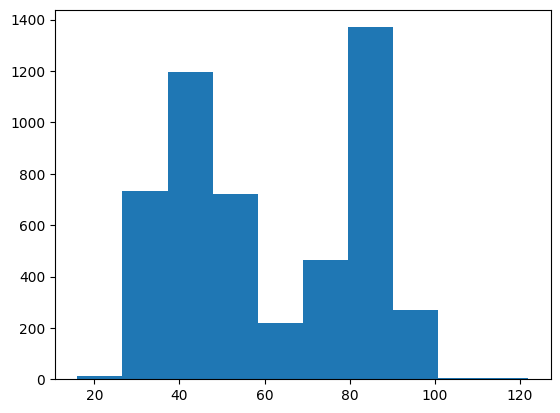

In [22]:
# Plotando a distribuição da idade em relação a base
plt.hist(x=data_consig['idade']);

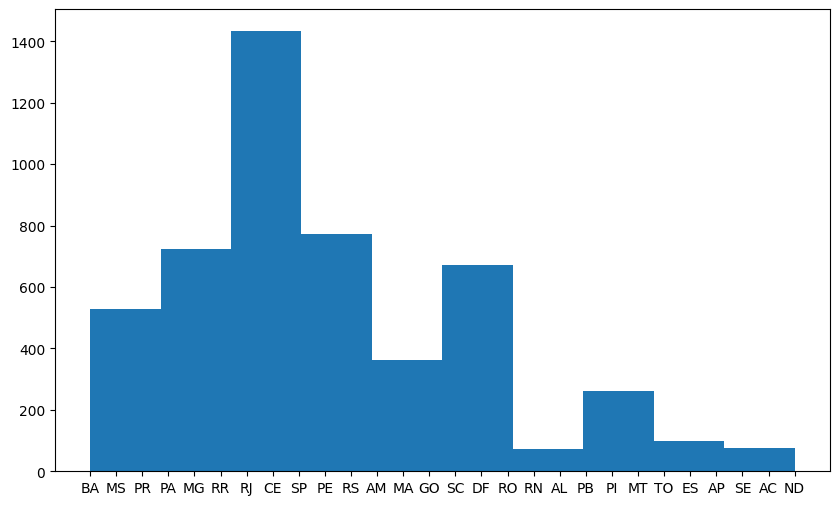

In [23]:
# Plotando a distribuição da idade em relação a base
plt.figure(figsize=(10, 6))
plt.hist(x=data_consig['uf']);

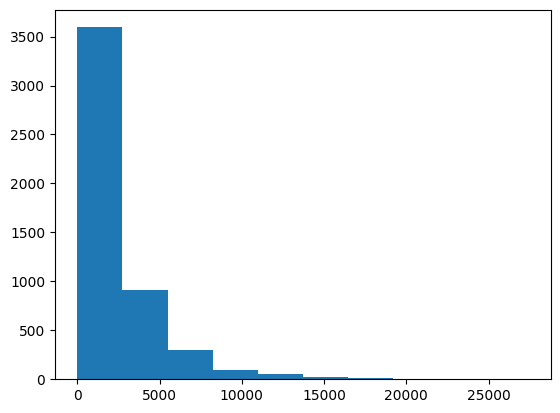

In [24]:
# Plotando a distribuição de parcelamento em relação a base
plt.hist(x=data_consig['pmt_valor']);

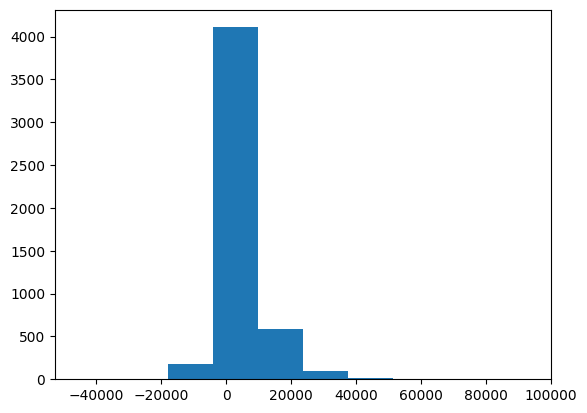

In [25]:
# Plotando a distribuição da margem em relação a base
plt.hist(x=data_consig['margem_saldo']);

**Tratamento de valores inconsistentes**
- Após análise dos dados, realizaremos o tratamento de valores inconsistentes. No caso, encontramos algumas idades superiores a 120 anos que podemos considerar pouco prováveis.

In [26]:
# Filtragem das idades superiores à 120
data_consig[data_consig['idade'] > 120.000000]

,sexo,idade,uf,situacao_funcional,tipo_contrato,pmt_valor,margem_saldo,conceder
1938,FEMININO,121,PR,APOSENTADO,ESTAVEL,1927.09,13027.80,1
1939,FEMININO,121,PR,APOSENTADO,ESTAVEL,2000.10,15636.96,1
1940,FEMININO,121,PR,APOSENTADO,ESTAVEL,2308.70,33805.71,1
3556,FEMININO,121,RS,APOSENTADO,ESTAVEL,243.96,17301.56,1
3938,FEMININO,122,ND,CONTRATO TEMPORARIO,NAO ESTAVEL,725.20,2.00,1


In [27]:
# Utilizaremos a idade média para correção sem considerar os dados errados
data_consig['idade'][data_consig['idade'] <= 120].mean()

60.812412412412414

In [28]:
# Realizando a correção
data_consig.loc[data_consig['idade'] > 105, 'idade'] = 60.812412412412414

# Verificando a atualização pelos índices
data_consig.head(1941)

,sexo,idade,uf,situacao_funcional,tipo_contrato,pmt_valor,margem_saldo,conceder
0,MASCULINO,40.000000,BA,ATIVO PERMANENTE,ESTAVEL,2011.71,-1309.80,1
1,MASCULINO,40.000000,BA,ATIVO PERMANENTE,ESTAVEL,3129.31,1104.00,1
2,MASCULINO,38.000000,MS,ATIVO PERMANENTE,ESTAVEL,976.12,235.91,1
3,MASCULINO,38.000000,MS,ATIVO PERMANENTE,ESTAVEL,2960.64,3684.51,1
4,FEMININO,89.000000,PR,APOSENTADO,ESTAVEL,422.80,12923.68,1
...,...,...,...,...,...,...,...,...
1936,FEMININO,36.000000,DF,BENEFICIARIO PENSAO,NAO ESTAVEL,136.00,805.82,0
1937,FEMININO,38.000000,CE,CELETISTA EMPREGADO,ESTAVEL,2439.24,179.92,1
1938,FEMININO,60.812412,PR,APOSENTADO,ESTAVEL,1927.09,13027.80,1
1939,FEMININO,60.812412,PR,APOSENTADO,ESTAVEL,2000.10,15636.96,1


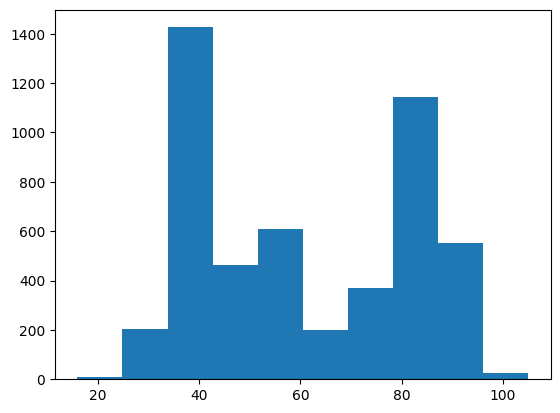

In [29]:
# Plotando a distribuição da idade em relação a base após a correção
plt.hist(x=data_consig['idade']);

In [30]:
# Gráfico para exibição da concessão do crédito pelo dataset, após a correção da idade
graph = px.scatter_matrix(data_consig, dimensions=['idade','uf','pmt_valor','margem_saldo'], color='conceder')
graph.show()

**Tratamento de valores faltantes (Não encontrado)**

In [31]:
# Buscar null em todos os registros
data_consig.isnull().sum()

sexo                  0
idade                 0
uf                    0
situacao_funcional    0
tipo_contrato         0
pmt_valor             0
margem_saldo          0
conceder              0
dtype: int64

**Análise de balanceamento por Oversampling**

In [32]:
# Funcão para contar os valores únicos da coluna "conceder" e verificar o balanceamento
np.unique(data_consig['conceder'], return_counts=True)

(array([0, 1]), array([1900, 3100]))

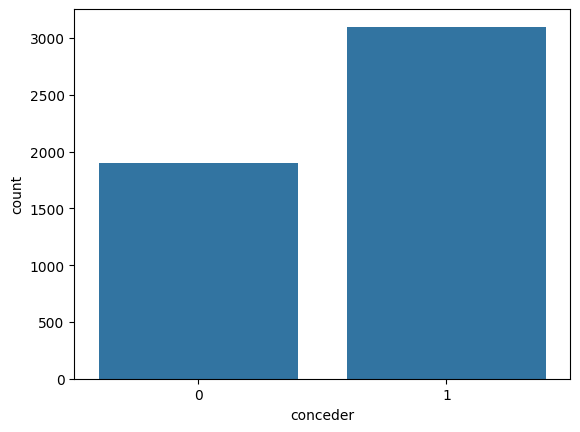

In [33]:
# Plotando em gráfico o balanceamento
sns.countplot(x=data_consig['conceder']);

In [34]:
# Dividir entre previsores e classes
X = data_consig.drop('conceder', axis=1)
y = data_consig[['conceder']]

# Codificar variáveis categóricas
label_encoder_sexo = LabelEncoder()
label_encoder_uf = LabelEncoder()
label_encoder_sit_func = LabelEncoder()
label_encoder_tp_cont = LabelEncoder()

X.iloc[:,0] = label_encoder_sexo.fit_transform(X.iloc[:,0])
X.iloc[:,2] = label_encoder_uf.fit_transform(X.iloc[:,2])
X.iloc[:,3] = label_encoder_sit_func.fit_transform(X.iloc[:,3])
X.iloc[:,4] = label_encoder_tp_cont.fit_transform(X.iloc[:,4])

# Holdout
X_consig_training, X_consig_test, y_consig_training, y_consig_test = train_test_split(X, y)


In [35]:
# Funcão para validação cruzada
def cross_validation(model, X_consig, y_consig, oversampling=False):
    kfold = KFold(n_splits=10)

    # lista de acurácias de cada split
    accuracy_split = []

    for idx,(idx_training, idx_validation) in enumerate(kfold.split(X_consig)):
        X_split_training = X_consig.iloc[idx_training,:]
        y_split_training = y_consig.iloc[idx_training,:]

        # oversampling, só no split de treino!
        if oversampling:
            sm = SMOTE(random_state=42)
            X_split_training, y_split_training = sm.fit_resample(X_split_training, y_split_training)

        # Treinando o modelo
        model.fit(X_split_training, y_split_training.values.flatten())

        X_split_validation = X_consig.iloc[idx_validation, :]
        y_split_validation = y_consig.iloc[idx_validation, :]

        # Validação SEM oversampling
        predict_validation = model.predict(X_split_validation)

        acuracia_split = accuracy_score(y_split_validation, predict_validation)

        accuracy_split.append(acuracia_split)

        print(f'Acurácia do split {idx}: {accuracy_split}')
    return accuracy_split

In [36]:
# Criando o modelo
model_hgb = HistGradientBoostingClassifier()

mean_accuracy_with_smote = mean(cross_validation(model_hgb, X_consig_training, y_consig_training, oversampling=False))
mean_accuracy_no_smote = mean(cross_validation(model_hgb, X_consig_training, y_consig_training, oversampling=True))

f'No smote: {mean_accuracy_no_smote:.02f}, with_smo: {mean_accuracy_with_smote:.02f}'

Acurácia do split 0: [0.9946666666666667]
Acurácia do split 1: [0.9946666666666667, 0.9946666666666667]
Acurácia do split 2: [0.9946666666666667, 0.9946666666666667, 0.9946666666666667]
Acurácia do split 3: [0.9946666666666667, 0.9946666666666667, 0.9946666666666667, 0.992]
Acurácia do split 4: [0.9946666666666667, 0.9946666666666667, 0.9946666666666667, 0.992, 0.9946666666666667]
Acurácia do split 5: [0.9946666666666667, 0.9946666666666667, 0.9946666666666667, 0.992, 0.9946666666666667, 0.984]
Acurácia do split 6: [0.9946666666666667, 0.9946666666666667, 0.9946666666666667, 0.992, 0.9946666666666667, 0.984, 0.9946666666666667]
Acurácia do split 7: [0.9946666666666667, 0.9946666666666667, 0.9946666666666667, 0.992, 0.9946666666666667, 0.984, 0.9946666666666667, 1.0]
Acurácia do split 8: [0.9946666666666667, 0.9946666666666667, 0.9946666666666667, 0.992, 0.9946666666666667, 0.984, 0.9946666666666667, 1.0, 0.9973333333333333]
Acurácia do split 9: [0.9946666666666667, 0.9946666666666667, 

'No smote: 0.99, with_smo: 0.99'

- Com Oversampling = 0,99
- Sem Oversampling = 0,99

Como podemos notar, não houve ganho aplicando Oversampling. Desta forma, **não iremos utilizá-lo**.

** Importante: realizamos essas análise, apenas em uma base de treinamento isolada.

**Holdout - Divisão das bases em treinamento e teste. No caso, dividiremos a base de treinamento em 75% e teste com 25%.**

In [37]:
# Divisão das bases de treinamento e teste
# Transformando as variáveis para numpy
X_consig = X.values
y_consig = y.values
X_consig_training, X_consig_test, y_consig_training, y_consig_test = train_test_split(X_consig, y_consig, test_size=0.25, random_state=10) #
X_consig_training.shape, y_consig_training.shape # Exibindo a dimensionalidade da base de treinamento

((3750, 7), (3750, 1))

In [38]:
# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=10) # validação cruzada com estratificação

LR: 0.781600 (0.018608)
KNN: 0.814400 (0.016958)
CART: 0.985867 (0.006751)
NB: 0.719467 (0.024753)
SVM: 0.807733 (0.014725)
Bagging: 0.990133 (0.005969)
RF: 0.991467 (0.003733)
ET: 0.973867 (0.006510)
Ada: 0.988800 (0.002872)
GB: 0.988800 (0.005307)
Voting: 0.927467 (0.012666)


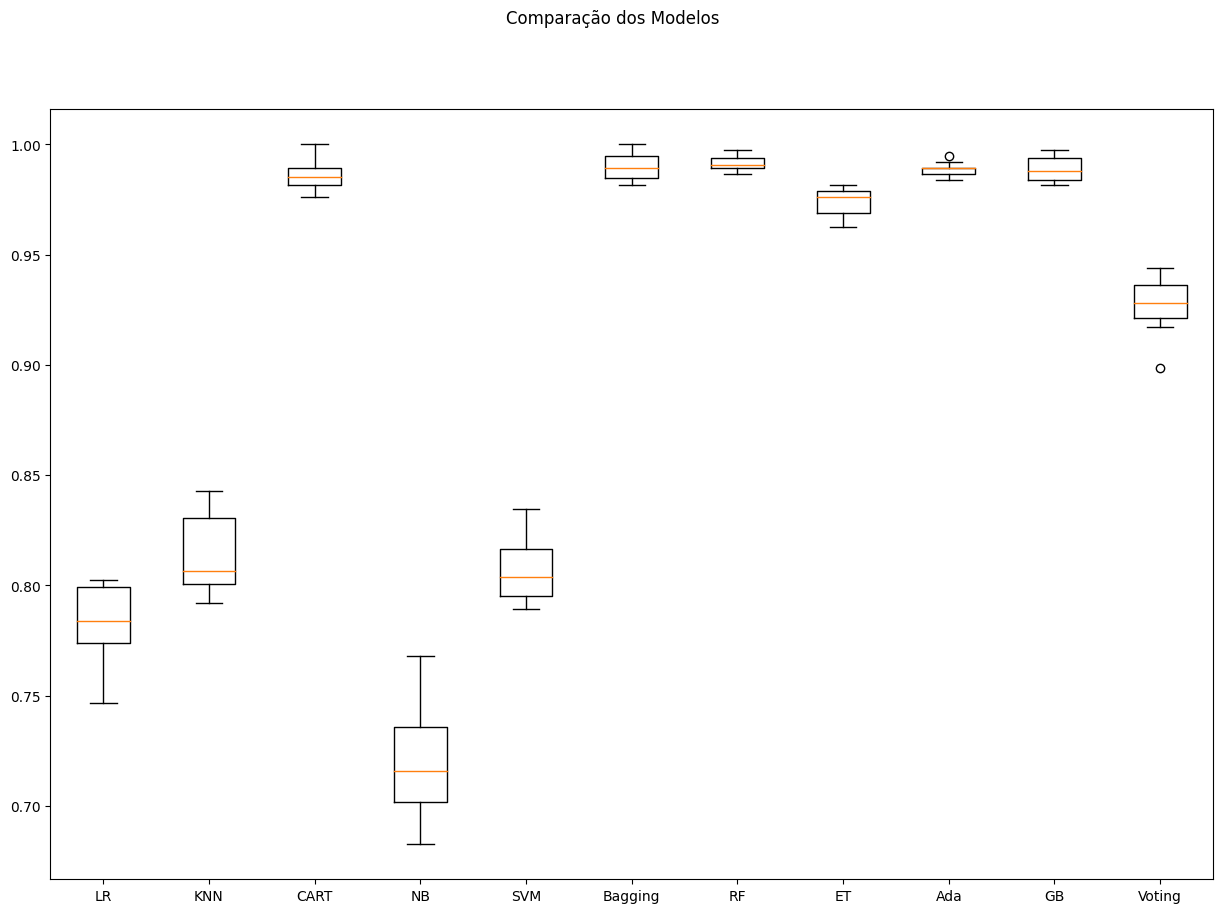

In [39]:
# Modelagem e Inferência
# Criação e avaliação de modelos: linha base
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_consig_training, y_consig_training, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

**Percebemos que o RandomForest teve um ótimo desempenho**

LR-orig: 0.782 (0.019)
KNN-orig: 0.814 (0.017)
CART-orig: 0.986 (0.007)
NB-orig: 0.719 (0.025)
SVM-orig: 0.808 (0.015)
Bag-orig: 0.990 (0.006)
RF-orig: 0.991 (0.004)
ET-orig: 0.974 (0.007)
Ada-orig: 0.989 (0.003)
GB-orig: 0.989 (0.005)
Vot-orig: 0.927 (0.013)
LR-padr: 0.783 (0.021)
KNN-padr: 0.889 (0.013)
CART-padr: 0.985 (0.008)
NB-padr: 0.701 (0.023)
SVM-padr: 0.925 (0.014)
Bag-padr: 0.989 (0.007)
RF-padr: 0.990 (0.005)
ET-padr: 0.972 (0.009)
Ada-padr: 0.989 (0.003)
GB-padr: 0.989 (0.005)
Vot-padr: 0.939 (0.014)
LR-norm: 0.767 (0.020)
KNN-norm: 0.864 (0.015)
CART-norm: 0.986 (0.007)
NB-norm: 0.701 (0.023)
SVM-norm: 0.816 (0.018)
Bag-norm: 0.990 (0.005)
RF-norm: 0.991 (0.006)
ET-norm: 0.973 (0.009)
Ada-norm: 0.989 (0.003)
GB-norm: 0.989 (0.005)
Vot-norm: 0.849 (0.017)


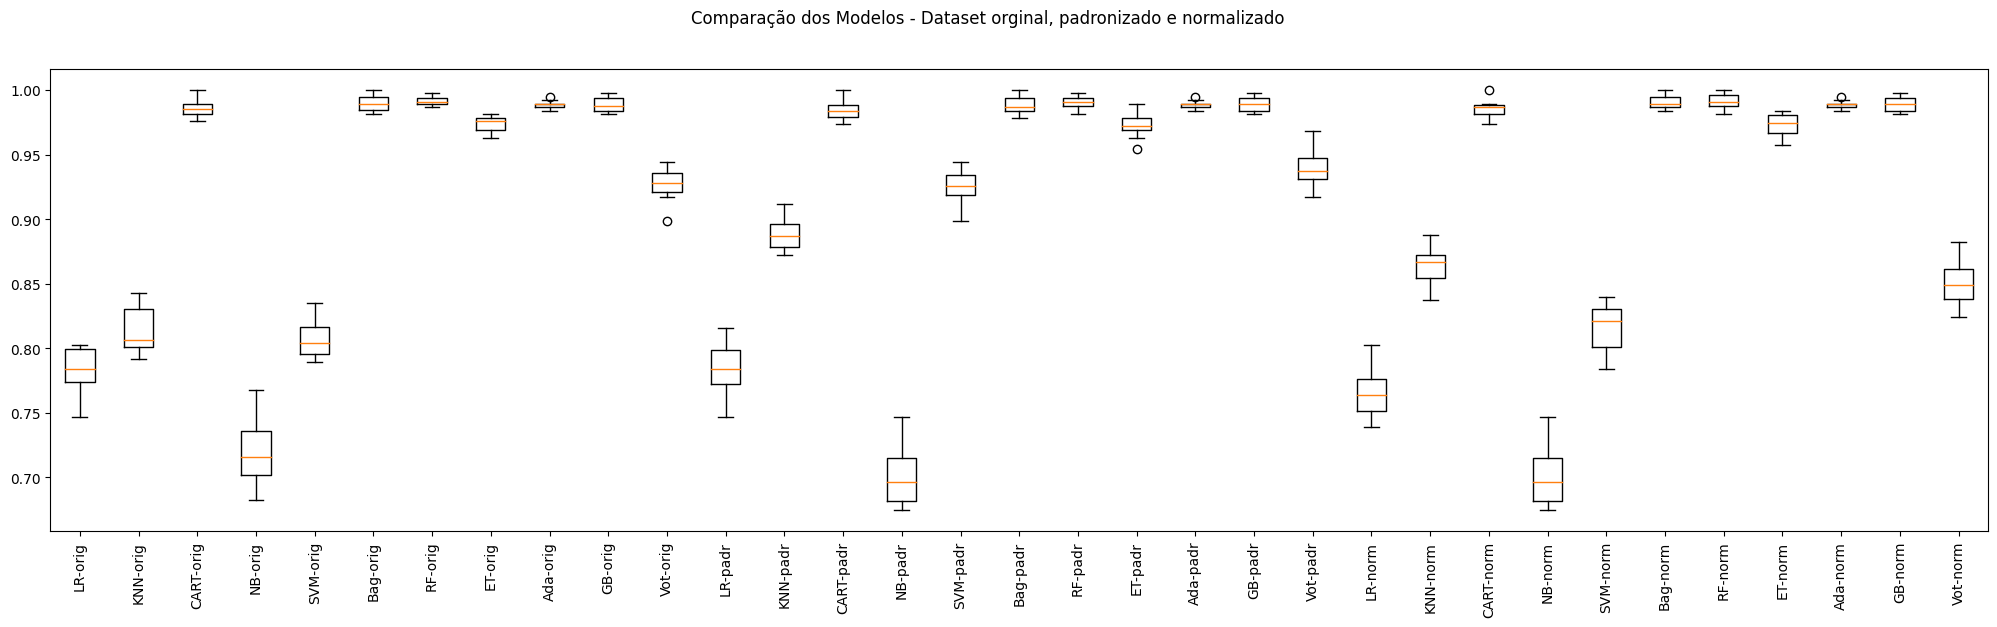

In [40]:
# Criação e avaliação de modelos: dados padronizados e normalizados

np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())



# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_consig_training, y_consig_training, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

**Não constatamos melhoras, após aplicarmos a padronização e normalização.**

In [41]:
# Otimização dos hiperparâmetros
# Tuning do RandomForestClassifier

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('RF-orig', Pipeline(steps=[random_forest])))
pipelines.append(('RF-padr', Pipeline(steps=[standard_scaler, random_forest])))
pipelines.append(('RF-norm', Pipeline(steps=[min_max_scaler, random_forest])))

param_grid = {
    'RF__n_estimators': [10,50,100],
    'RF__max_depth': [5, 10, 15],
    'RF__criterion': ['gini','entropy','log_loss'],
    'RF__max_features': [0.5, 1.0, 1.5],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_consig_training, y_consig_training)
    # imprime a melhor configuração
    #print("Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))
    print(name,grid.best_score_,grid.best_params_)

RF-orig 0.9925333333333335 {'RF__criterion': 'entropy', 'RF__max_depth': 15, 'RF__max_features': 1.0, 'RF__n_estimators': 100}
RF-padr 0.9928000000000001 {'RF__criterion': 'log_loss', 'RF__max_depth': 15, 'RF__max_features': 1.0, 'RF__n_estimators': 50}
RF-norm 0.9925333333333335 {'RF__criterion': 'entropy', 'RF__max_depth': 15, 'RF__max_features': 1.0, 'RF__n_estimators': 50}


**Após ajustarmos os hiperparâmetros, também não percebemos melhoras significativas.**

In [42]:
# Finalização do Modelo
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_consig_training) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_consig_training) # aplicação da padronização no conjunto de treino
model = RandomForestClassifier(n_estimators=50, max_features=1.0, criterion='log_loss', max_depth=15)
model.fit(rescaledX, y_consig_training)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_consig_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_consig_test, predictions))

0.9896


In [43]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X_consig) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X_consig) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y_consig)

RandomForestClassifier(criterion='log_loss', max_depth=15, max_features=1.0,
                       n_estimators=50)

In [44]:
# Matriz de confusão
confusion_matrix(y_consig_test, predictions)

array([[454,   6],
       [  7, 783]])

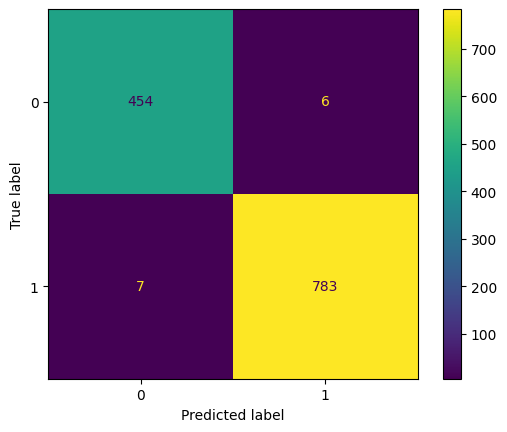

In [45]:
# Visualizando através do gráfico da matriz de confusão
cm = confusion_matrix(y_consig_test, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot()

**Análise da Matriz de Confusão**

- Verdadeiro Positivo: 455 - Quando o classificador previu SIM (CONCEDER = 0) e a classe correta é SIM (CONCEDER=0)
- Verdadeiro Negativo: 785 - Quando o classificador previu NÂO (CONCEDER = 1) e a classe correta é NÂO (CONCEDER=1)
- Falso Positivo: 5 - Quando o classificador previu SIM (CONCEDER = 0) e a classe correta é NÂO (CONCEDER = 1)
- Falso Negativo: 5 - Quando o classificador previu NÂO (CONCEDER = 1) e a classe correta é SIM (CONCEDER = 0)

Total de Registros: 1250
Taxa de acerto (acurácia): (455 + 785) / 1250 = 0,992


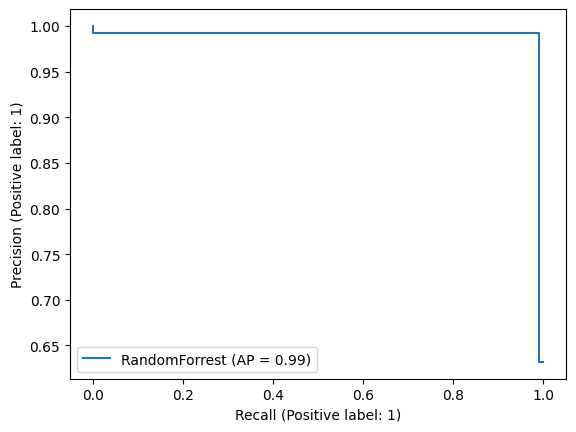

In [46]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(y_consig_test, predictions, name="RandomForrest")
plt.show()

***Importante: Essa plotagem não permite o aumento de casas decimais!!!***

Análise de Precision e Recall

**Precision**

Quando o modelo previu SIM, o quanto ele estava certo?
- 455 / (455 + 5) = 0,989
- O modelo identifica corretamente 99% para concessão do crédito

**Recall**
- 455 / (455 + 5) = 0,989
- O modelo identifica corretamente 99% de toda base

In [47]:
# Simulando a aplicação do modelo em dados não vistos
# Novos dados - não sabemos a classe!
data = {'sexo': ['MASCULINO', 'MASCULINO', 'FEMININO'],
        'idade': [90, 30, 56],
        'uf': ['RJ', 'BA', 'SP'],
        'situacao_funcional':['ATIVO PERMANENTE','APOSENTADO', 'APOSENTADO'],
        'tipo_contrato': ['ESTAVEL', 'ESTAVEL', 'NAO ESTAVEL'],
        'pmt_valor': [100, 500, 35000],
        'margem_saldo': [200, 5000, 4000],
        }

atributos = ['sexo','idade','uf','situacao_funcional','tipo_contrato', 'pmt_valor', 'margem_saldo']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:7]


# Codificar variáveis categóricas
label_encoder_sex = LabelEncoder()
label_encoder_u = LabelEncoder()
label_encoder_sit_fun = LabelEncoder()
label_encoder_tp_con = LabelEncoder()
X_entrada[:,0] = label_encoder_sex.fit_transform(X_entrada[:,0])
X_entrada[:,2] = label_encoder_u.fit_transform(X_entrada[:,2])
X_entrada[:,3] = label_encoder_sit_fun.fit_transform(X_entrada[:,3])
X_entrada[:,4] = label_encoder_tp_con.fit_transform(X_entrada[:,4])

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[ 1.23656155e+00  1.37189553e+00 -1.83751337e+00 -1.24936346e+00
  -4.40973600e-01 -7.73886984e-01 -5.06432696e-01]
 [ 1.23656155e+00 -1.44826669e+00 -1.97734606e+00 -1.65864193e+00
  -4.40973600e-01 -6.30180789e-01  1.30429089e-01]
 [-8.08694075e-01 -2.26196395e-01 -1.69768069e+00 -1.65864193e+00
   2.26770945e+00  1.17644784e+01 -2.25044957e-03]]


In [48]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[1 0 1]


**Resumo:**

Conforme saída acima, o modelo "preditou" corretamente os dados não vistos, respeitando a regra de negócio (A regrá principal consiste em ser menor que 85 anos de idade, com margem de saldo superior à 35% dos parcelamentos vigentes), somente o segundo registro está correto.

